<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

# PlantTraits2024 - FGVC11 with [KerasCV](https://github.com/keras-team/keras-cv) and [Keras](https://github.com/keras-team/keras)

> The objective of this competition is to uncover the biosphere, specifically to predict a broad set of 6 plant traits (e.g., leaf area, plant height) from crowd-sourced plant images and some ancillary data.

<div align="center">
  <img src="https://i.ibb.co/C5zZ2nf/header.jpg">
</div>

This notebook guides you through the process of training and inferring a multi-input and multi-output Deep Learning model, specifically using the EfficientNetV2 backbone from KerasCV on the competition dataset. Specifically, this notebook uses both plant image data and ancillary tabular features to identify plant traits.

Fun fact: This notebook is backend-agnostic, supporting TensorFlow, PyTorch, and JAX. Utilizing KerasCV and Keras allows us to choose our preferred backend. Explore more details on [Keras](https://keras.io/keras_core/announcement/).

In this notebook, you will learn:

- Dsigning a data pipeline for a multi-input and multi-output model.
- Creating random augmentation pipeline with KerasCV.
- Loading the data efficiently using [`tf.data`](https://www.tensorflow.org/guide/data).
- Creating the model using KerasCV presets.
- Training the model.
- Inference and Submission on test data.

**Note**: For a more in-depth understanding of KerasCV, refer to the [KerasCV guides](https://keras.io/guides/keras_cv/).

# 🛠 | Install Libraries  

Since internet access is **disabled** during inference, we cannot install libraries in the usual `!pip install <lib_name>` manner. Instead, we need to install libraries from local files. In the following cell, we will install libraries from our local files. The installation code stays very similar - we just use the `filepath` instead of the `filename` of the library. So now the code is `!pip install <local_filepath>`. 

> The `filepath` of these local libraries look quite complicated, but don't be intimidated! Also `--no-deps` argument ensures that we are not installing any additional libraries.

In [8]:
!pip install -q /kaggle/input/kerasv3-lib-ds/keras_cv-0.8.2-py3-none-any.whl --no-deps
!pip install -q /kaggle/input/kerasv3-lib-ds/tensorflow-2.15.0.post1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl --no-deps
!pip install -q /kaggle/input/kerasv3-lib-ds/keras-3.0.4-py3-none-any.whl --no-deps

# 📚 | Import Libraries 

In [9]:
import os
os.environ["KERAS_BACKEND"] = "jax" # you can also use tensorflow or torch

import keras_cv
import keras
from keras import ops
import tensorflow as tf

import cv2
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib

import matplotlib.pyplot as plt 

## Library Versions

In [10]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.15.0
Keras: 3.0.4
KerasCV: 0.8.2


# ⚙️ | Configuration

In [11]:
class CFG:
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    preset = "efficientnetv2_b2_imagenet"  # Name of pretrained classifier
    image_size = [224, 224]  # Input image size
    epochs = 12 # Training epochs
    batch_size = 96  # Batch size
    lr_mode = "step" # LR scheduler mode from one of "cos", "step", "exp"
    drop_remainder = True  # Drop incomplete batches
    num_classes = 6 # Number of classes in the dataset
    num_folds = 5 # Number of folds to split the dataset
    fold = 0 # Which fold to set as validation data
    class_names = ['X4_mean', 'X11_mean', 'X18_mean',
                   'X26_mean', 'X50_mean', 'X3112_mean',]
    aux_class_names = list(map(lambda x: x.replace("mean","sd"), class_names))
    num_classes = len(class_names)
    aux_num_classes = len(aux_class_names)

# ♻️ | Reproducibility 
Sets value for random seed to produce similar result in each run.

In [12]:
keras.utils.set_random_seed(CFG.seed)

# 📁 | Dataset Path 

In [13]:
BASE_PATH = "/kaggle/input/planttraits2024"

# 📖 | Meta Data

In this dataset, we have information on `6` different plant traits. Here, **plant trait** refers to various characteristics or features of plants, such as leaf area or plant height. In this competition, we aim to predict the **average** of these traits, indicated as `X[*]_mean`, for each species. Additionally, in the training dataset, we are provided with the **standard deviation** of these traits, indicated by `X[*]_sd`, for each species. In our notebook, we will consider estimating the `mean` of traits as our main task and determining the `sd` as our auxiliary task. The description of each trait can be found in the table below:

| trait_ID | trait_name                                                                                 |
|----------|--------------------------------------------------------------------------------------------|
| X4       | Stem specific density (SSD) or wood density (stem dry mass per stem fresh volume)          |
| X11      | Leaf area per leaf dry mass (specific leaf area, SLA or 1/LMA)                              |
| X18      | Plant height                                                                               |
| X26      | Seed dry mass                                                                              |
| X50      | Leaf nitrogen (N) content per leaf area                                                   |
| X3112    | Leaf area (in the case of compound leaves: leaf, undefined if petiole in- or excluded)     |

> **Note**: Even though in the `train.csv` file target labels / columns are named as `X[*]_mean`, in the `submission.csv` file they are named as `X[*]`.

In [14]:
# Train + Valid
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['image_path'] = f'{BASE_PATH}/train_images/'+df['id'].astype(str)+'.jpeg'
df.loc[:, CFG.aux_class_names] = df.loc[:, CFG.aux_class_names].fillna(-1)
display(df.head(2))

# Test
test_df = pd.read_csv(f'{BASE_PATH}/test.csv')
test_df['image_path'] = f'{BASE_PATH}/test_images/'+test_df['id'].astype(str)+'.jpeg'
FEATURE_COLS = test_df.columns[1:-1].tolist()
display(test_df.head(2))

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,image_path
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054,/kaggle/input/planttraits2024/train_images/192...
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477,/kaggle/input/planttraits2024/train_images/195...


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12,image_path
0,195066138,10.55810,961.500000,31.586735,13.728325,648.038208,25.351532,127,152,137,...,0.469694,0.455849,0.528211,0.555653,0.549882,0.542905,0.517507,0.462724,0.427107,/kaggle/input/planttraits2024/test_images/1950...
1,195524180,7.00287,1120.025513,23.000000,7.258863,973.889404,39.135712,106,167,127,...,0.428838,0.456266,0.470074,0.468038,0.475943,0.483206,0.477197,0.432732,0.423728,/kaggle/input/planttraits2024/test_images/1955...


# 🍚 | DataLoader

This DataLoader simultaneously processes JPEG `images` and tabular `features` as inputs. It also handles labels for both main and auxiliary tasks. Then, it applies augmentations such as `flip`, `rotation`, `brightness`, etc. Unlike typical augmentations, these augmentations are applied to a batch, which speeds up training and reduces CPU bottleneck.

In [15]:
def build_augmenter():
    # Define augmentations
    aug_layers = [
        keras_cv.layers.RandomBrightness(factor=0.1, value_range=(0, 1)),
        keras_cv.layers.RandomContrast(factor=0.1, value_range=(0, 1)),
        keras_cv.layers.RandomSaturation(factor=(0.45, 0.55)),
        keras_cv.layers.RandomHue(factor=0.1, value_range=(0, 1)),
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.15), width_factor=(0.06, 0.15)),
        keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
        keras_cv.layers.RandomZoom(height_factor=(0.05, 0.15)),
        keras_cv.layers.RandomRotation(factor=(0.01, 0.05)),
    ]
    
    # Apply augmentations to random samples
    aug_layers = [keras_cv.layers.RandomApply(x, rate=0.5) for x in aug_layers]
    
    # Build augmentation layer
    augmenter = keras_cv.layers.Augmenter(aug_layers)

    # Apply augmentations
    def augment(inp, label):
        images = inp["images"]
        aug_data = {"images": images}
        aug_data = augmenter(aug_data)
        inp["images"] = aug_data["images"]
        return inp, label
    return augment


def build_decoder(with_labels=True, target_size=CFG.image_size):
    def decode_image(inp):
        path = inp["images"]
        
        # Read jpeg image
        file_bytes = tf.io.read_file(path)
        image = tf.io.decode_jpeg(file_bytes)
        
        # Resize
        image = tf.image.resize(image, size=target_size, method="area")
        
        # Rescale image
        image = tf.cast(image, tf.float32)
        image /= 255.0
        
        # Reshape
        image = tf.reshape(image, [*target_size, 3])
        
        inp["images"] = image
        return inp

    def decode_label(label, num_classes):
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [num_classes])
        return label

    def decode_with_labels(inp, labels=None):
        inp = decode_image(inp)
        label = decode_label(labels[0], CFG.num_classes)
        aux_label = decode_label(labels[1], CFG.aux_num_classes)
        return (inp, (label, aux_label))

    return decode_with_labels if with_labels else decode_image


def build_dataset(
    paths,
    features,
    labels=None,
    aux_labels=None,
    batch_size=32,
    cache=True,
    decode_fn=None,
    augment_fn=None,
    augment=False,
    repeat=True,
    shuffle=1024,
    cache_dir="",
    drop_remainder=False,
):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None or aux_labels is not None)

    if augment_fn is None:
        augment_fn = build_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE

    inp = {"images": paths, "features": features}
    slices = (inp, (labels, aux_labels)) if labels is not None else inp

    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle:
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

## 🔪 | Data Split

In the following code, we will split the data into `5` stratified folds. It first creates bins based on `6` plant traits distributions and combines them into a final bin column. Then, it uses this bin for balancing similar traits distributions across all folds.


In [16]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=CFG.num_folds, shuffle=True, random_state=42)

# Create separate bin for each traits
for i, trait in enumerate(CFG.class_names):

    # Determine the bin edges dynamically based on the distribution of traits
    bin_edges = np.percentile(df[trait], np.linspace(0, 100, CFG.num_folds + 1))
    df[f"bin_{i}"] = np.digitize(df[trait], bin_edges)

# Concatenate the bins into a final bin
df["final_bin"] = (
    df[[f"bin_{i}" for i in range(len(CFG.class_names))]]
    .astype(str)
    .agg("".join, axis=1)
)

# Perform the stratified split using final bin
df = df.reset_index(drop=True)
for fold, (train_idx, valid_idx) in enumerate(skf.split(df, df["final_bin"])):
    df.loc[valid_idx, "fold"] = fold

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


## Build Train & Valid Dataset

In the following code, we'll create **train** and **valid** data loaders. When dealing with tabular features (ancillary data), there are typically several processing steps involved. In this competition, however, the tabular data consists only of continuous, non-categorical features, which simplifies our task. Thus, we don't need to encode any categories. Before passing the tabular `features` to the model, we apply standard normalization using `StandardScaler`. This normalization step ensures that features have consistent scales, which is crucial for optimal performance of `Dense` or `Linear` layers. Readers are encouraged to experiment with advanced feature processing with raw features.

> **Note**: The data loader processes (`image`, `label`) for the main task, and (`feature`, `aux_label`) for the auxiliary task.

In [17]:
from sklearn.preprocessing import StandardScaler

# Sample from full data
sample_df = df.copy()
train_df = sample_df[sample_df.fold != CFG.fold]
valid_df = sample_df[sample_df.fold == CFG.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Normalize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[FEATURE_COLS].values)
valid_features = scaler.transform(valid_df[FEATURE_COLS].values)

# Train
train_paths = train_df.image_path.values
train_labels = train_df[CFG.class_names].values
train_aux_labels = train_df[CFG.aux_class_names].values
train_ds = build_dataset(train_paths, train_features, train_labels, train_aux_labels,
                         batch_size=CFG.batch_size,
                         repeat=True, shuffle=True, augment=True, cache=False)

# Valid
valid_paths = valid_df.image_path.values
valid_labels = valid_df[CFG.class_names].values
valid_aux_labels = valid_df[CFG.aux_class_names].values
valid_ds = build_dataset(valid_paths, valid_features, valid_labels, valid_aux_labels,
                         batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=False)


# Num Train: 44391 | Num Valid: 11098


## Dataset Check

Let's visualize some samples and their associated labels from the dataset.

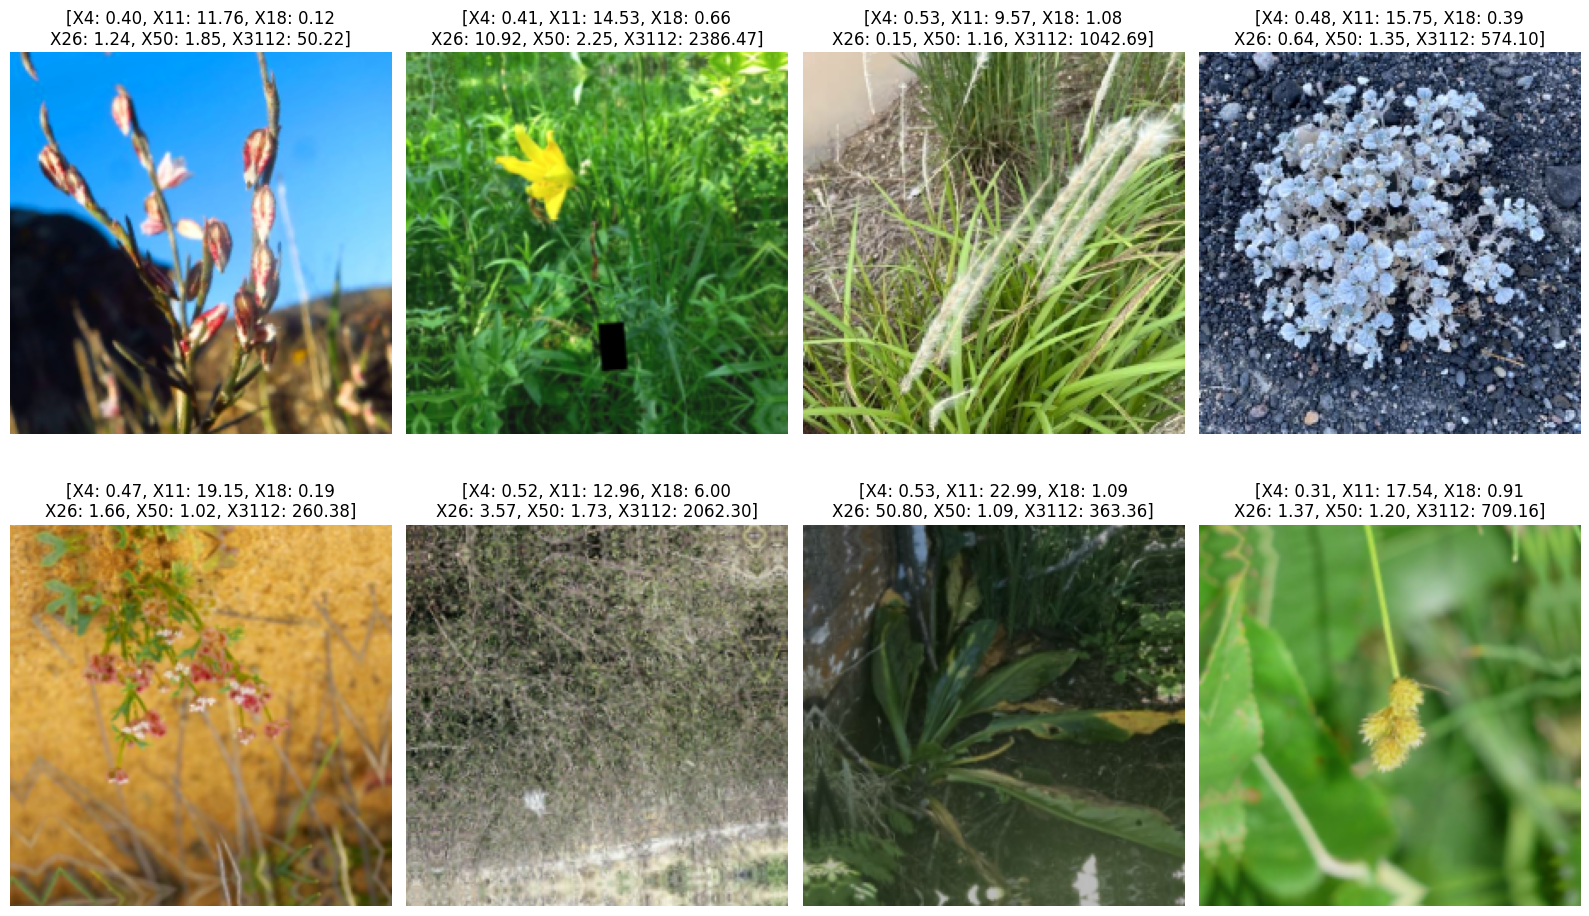

In [18]:
inps, tars = next(iter(train_ds))
imgs = inps["images"]
num_imgs, num_cols = 8, 4

plt.figure(figsize=(4 * num_cols, num_imgs // num_cols * 5))
for i, (img, tar) in enumerate(zip(imgs[:num_imgs], tars[0][:num_imgs])):
    plt.subplot(num_imgs // num_cols, num_cols, i + 1)
    img = img. numpy()
    tar = tar.numpy()
    
    img = (img - img.min()) / (img.max() + 1e-4)

    formatted_tar = "\n".join(
        [
            ", ".join(
                f"{name.replace('_mean','')}: {val:.2f}"
                for name, val in zip(CFG.class_names[j : j + 3], tar[j : j + 3])
            )
            for j in range(0, len(CFG.class_names), 3)
        ]
    )

    plt.imshow(img)
    plt.title(f"[{formatted_tar}]")
    plt.axis("off")

plt.tight_layout()
plt.show()

# 🔍 | Loss & Metric

The evaluation metric in this competition is $R^2$ (coefficient of determination) is defined as:

$$
\begin{equation}
\begin{aligned}
R^2 &= 1 - \frac{SS_{\text{residual}}}{SS_{\text{total}}} \\
    &= 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}
\end{aligned}
\end{equation}
$$

Where:
- $SS$ is sum of squares.
- $n$ is the number of samples.
- $y_i$ is the true value of the $i^{th}$ sample.
- $\hat{y}_i$ is the predicted value of the $i^{th}$ sample.
- $\bar{y}$ is the mean of the true values.

In our notebook, we will use $\frac{SS_{residual}}{SS_{total}}$ as loss function and use $R^2$ as evaluation metric. For auxiliary task, where some samples don't have target labels, we will exclude them from the loss calculation using `use_mask` argument.

In [19]:
from keras import ops

class R2Loss(keras.losses.Loss):
    def __init__(self, use_mask=False, name="r2_loss"):
        super().__init__(name=name)
        self.use_mask = use_mask

    def call(self, y_true, y_pred):
        if self.use_mask:
            mask = (y_true != -1)
            y_true = ops.where(mask, y_true, 0.0)
            y_pred = ops.where(mask, y_pred, 0.0)
        SS_res = ops.sum(ops.square(y_true - y_pred), axis=0)  # (B, C) -> (C,)
        SS_tot = ops.sum(ops.square(y_true - ops.mean(y_true, axis=0)), axis=0)  # (B, C) -> (C,)
        r2_loss = SS_res / (SS_tot + 1e-6)  # (C,)
        return ops.mean(r2_loss)  # ()
    
class R2Metric(keras.metrics.Metric):
    def __init__(self, name="r2", **kwargs):
        super(R2Metric, self).__init__(name=name, **kwargs)
        self.SS_res = self.add_weight(name='SS_res', shape=(6,), initializer='zeros')
        self.SS_tot = self.add_weight(name='SS_tot', shape=(6,) ,initializer='zeros')
        self.num_samples = self.add_weight(name='num_samples', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        SS_res = ops.sum(ops.square(y_true - y_pred), axis=0)
        SS_tot = ops.sum(ops.square(y_true - ops.mean(y_true, axis=0)), axis=0)
        self.SS_res.assign_add(SS_res)
        self.SS_tot.assign_add(SS_tot)
        self.num_samples.assign_add(ops.cast(ops.shape(y_true)[0], "float32"))

    def result(self):
        r2 = 1 - self.SS_res / (self.SS_tot + 1e-6)
        return ops.mean(r2)

    def reset_states(self):
        self.total_SS_res.assign(0)
        self.total_SS_tot.assign(0)
        self.num_samples.assign(0)

# 🤖 | Modeling

In this notebook, we utilize the `EfficientNetV2 B2` backbone from KerasCV's pretrained models to extract features from images and `Dense` layers to extract features from tabular data. We then employ two `Dense` layers as our final layers (heads): one without activation (for the **main task**) and the other with `relu` activation (for the **auxiliary task**). We choose `relu` for the auxiliary task because we are estimating the **standard deviation** of plant traits, which is always **positive**. This is similar to how we use `sigmoid` activation when the target variable ranges between `0` and `1`.

To explore other backbones, simply modify the `preset` in the `CFG` (config). A list of available pretrained backbones can be found on the [KerasCV website](https://keras.io/api/keras_cv/models/).

## Model Architecture Overview

- Image input → Main Task → Head
- Tabular input → Auxiliary Task → Aux Head

> **Note:** We assign more weight to the `head` than the `aux_head` since it is our main task, and our evaluation metric is calculated for the `head`, not the `aux_head`."

In [20]:
# Define input layers
img_input = keras.Input(shape=(*CFG.image_size, 3), name="images")
feat_input = keras.Input(shape=(len(FEATURE_COLS),), name="features")

# Branch for image input
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(CFG.preset)
x1 = backbone(img_input)
x1 = keras.layers.GlobalAveragePooling2D()(x1)
x1 = keras.layers.Dropout(0.2)(x1)

# Branch for tabular/feature input
x2 = keras.layers.Dense(326, activation="selu")(feat_input)
x2 = keras.layers.Dense(64, activation="selu")(x2)
x2 = keras.layers.Dropout(0.1)(x2)

# Concatenate both branches
concat = keras.layers.Concatenate()([x1, x2])

# Output layer
out1 = keras.layers.Dense(CFG.num_classes, activation=None, name="head")(concat)
out2 = keras.layers.Dense(CFG.aux_num_classes, activation="relu", name="aux_head")(concat)
out = {"head": out1, "aux_head":out2}

# Build model
model = keras.models.Model([img_input, feat_input], out)

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss={
        "head": R2Loss(use_mask=False),
        "aux_head": R2Loss(use_mask=True), # use_mask to ignore `NaN` auxiliary labels
    },
    loss_weights={"head": 1.0, "aux_head": 0.3},  # more weight to main task
    metrics={"head": R2Metric()}, # evaluation metric only on main task
)

# Model Summary
model.summary()

Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer) │ (None, 224, 224,  │       0 │ -                    │
│                     │ 3)                │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ features            │ (None, 163)       │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ efficient_net_v2b2… │ (None, 7, 7,      │ 8,769,… │ images[0][0]         │
│ (EfficientNetV2Bac… │ 1408)             │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense (Dense)       │ (None, 326)       │  53,464 │ features[0][0]       │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ global_average_poo… │ (None, 1408)      │       0 │ efficient_net_v2b2_… │
│ (GlobalAveragePool… │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │  20,928 │ dense[0][0]          │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout (Dropout)   │ (None, 1408)      │       0 │ global_average_pool… │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │       0 │ dense_1[0][0]        │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ concatenate         │ (None, 1472)      │       0 │ dropout[0][0],       │
│ (Concatenate)       │                   │         │ dropout_1[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ aux_head (Dense)    │ (None, 6)         │   8,838 │ concatenate[0][0]    │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ head (Dense)        │ (None, 6)         │   8,838 │ concatenate[0][0]    │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 8,861,442 (33.80 MB)

 Trainable params: 8,779,154 (33.49 MB)

 Non-trainable params: 82,288 (321.44 KB)

## Plot Model

As our model is multi-input and multi-output, it is difficult to understand what is going on inside the architecture. That is where `plot_model` from **Keras** can be very handy. We can draw the overall architecture, making it easier to design or recheck our architecture.

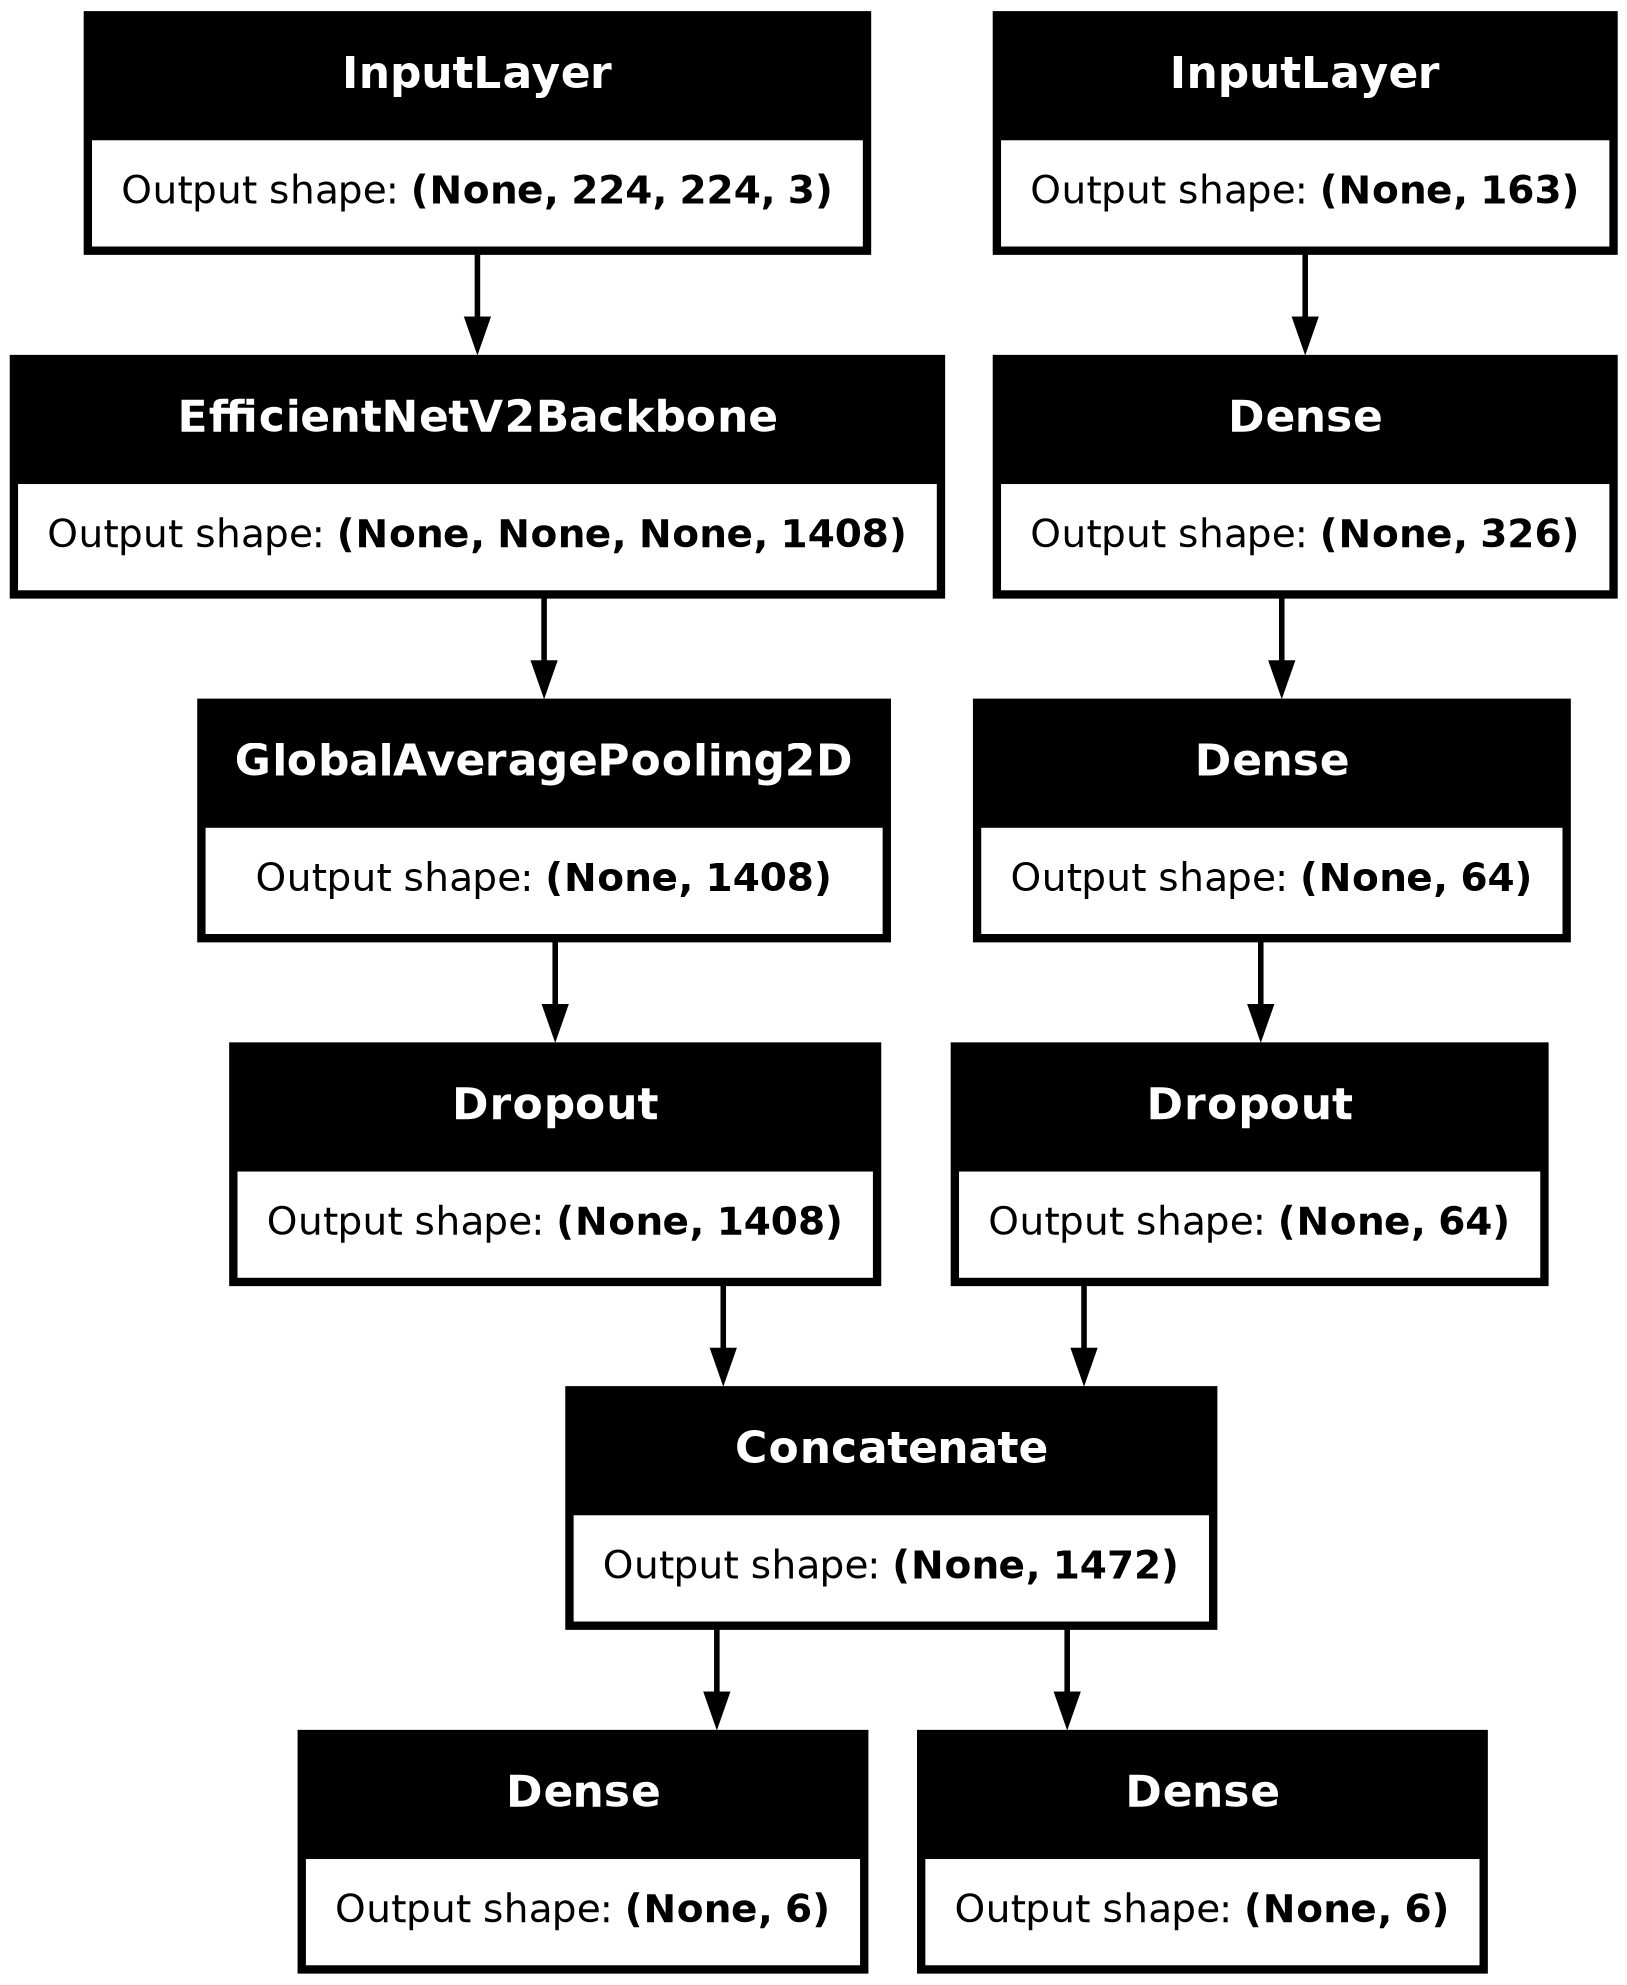

In [21]:
keras.utils.plot_model(model, show_shapes=True)

# ⚓ | LR Schedule

A well-structured learning rate schedule is essential for efficient model training, ensuring optimal convergence and avoiding issues such as overshooting or stagnation.

In [22]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 8e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

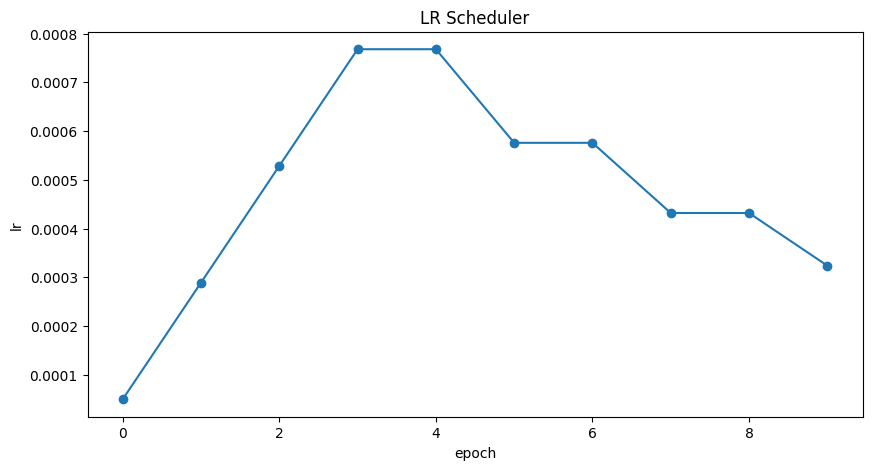

In [23]:
lr_cb = get_lr_callback(CFG.batch_size, mode=CFG.lr_mode, plot=True)

# 💾 | Model Checkpoint

In [24]:
ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    monitor="val_head_r2",
    save_best_only=True,
    save_weights_only=False,
    mode="max",
)

# 🚂 | Training

In [25]:
history = model.fit(
    train_ds,
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb],
    steps_per_epoch=len(train_df) // CFG.batch_size,
    validation_data=valid_ds,
    verbose=CFG.verbose,
)

Epoch 1/12
462/462 ━━━━━━━━━━━━━━━━━━━━ 586s 1s/step - head_r2: -0.0839 - loss: 1.7823 - val_head_r2: 0.0227 - val_loss: 1.3590 - learning_rate: 5.0000e-05
Epoch 2/12
462/462 ━━━━━━━━━━━━━━━━━━━━ 466s 1s/step - head_r2: -0.0168 - loss: 1.3712 - val_head_r2: 0.0344 - val_loss: 1.2399 - learning_rate: 2.8933e-04
Epoch 3/12
462/462 ━━━━━━━━━━━━━━━━━━━━ 468s 1s/step - head_r2: -6.7038e-04 - loss: 1.2739 - val_head_r2: 0.0337 - val_loss: 1.2150 - learning_rate: 5.2867e-04
Epoch 4/12
462/462 ━━━━━━━━━━━━━━━━━━━━ 461s 999ms/step - head_r2: 0.0077 - loss: 1.2398 - val_head_r2: 0.0343 - val_loss: 1.2087 - learning_rate: 7.6800e-04
Epoch 5/12
462/462 ━━━━━━━━━━━━━━━━━━━━ 457s 991ms/step - head_r2: 0.0180 - loss: 1.2114 - val_head_r2: 0.0383 - val_loss: 1.1982 - learning_rate: 7.6800e-04
Epoch 6/12
462/462 ━━━━━━━━━━━━━━━━━━━━ 457s 990ms/step - head_r2: 0.0264 - loss: 1.1860 - val_head_r2: 0.0424 - val_loss: 1.1883 - learning_rate: 5.7600e-04
Epoch 7/12
462/462 ━━━━━━━━━━━━━━━━━━━━ 452s 979ms/ste

# 📋 | Result

In [26]:
# Best Result
best_R2 = max(history.history['val_head_r2'])
best_Epoch = np.argmax(history.history['val_head_r2']) + 1
print("#" * 10 + " Result " + "#" * 10)
print(f"Best R2: {best_R2:.5f}")
print(f"Best Epoch: {best_Epoch}")
print("#" * 28)

########## Result ##########
Best R2: 0.04388
Best Epoch: 7
############################


# 🧪 | Prediction

## Load Best Model

In [32]:
model.load_weights("best_model.keras")

## Build Test Dataset

Don't forget to normalize for the test data as well.

In [28]:
# Test
test_paths = test_df.image_path.values
test_features = scaler.transform(test_df[FEATURE_COLS].values) 
test_ds = build_dataset(test_paths, test_features, batch_size=CFG.batch_size,
                         repeat=False, shuffle=False, augment=False, cache=False)

## Inference

As our model outputs predictions for two tasks and our submission requires only one, we will take predictions from the main task (`head`) and ignore predictions from the auxiliary task.

In [29]:
preds = model.predict(test_ds)["head"]

145/145 ━━━━━━━━━━━━━━━━━━━━ 55s 328ms/step


# 📩 | Submission

In [30]:
pred_df = test_df[["id"]].copy()
target_cols = [x.replace("_mean","") for x in CFG.class_names]
pred_df[target_cols] = preds.tolist()

sub_df = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
sub_df = sub_df[["id"]].copy()
sub_df = sub_df.merge(pred_df, on="id", how="left")
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

,id,X4,X11,X18,X26,X50,X3112
0,195066138,-0.125384,1.188805,0.042915,0.782682,-0.027105,122.210991
1,195524180,0.212957,2.180818,3.041163,9.130399,0.408051,195.607651
2,172220512,-0.193205,0.582379,0.031550,4.163519,-0.147522,186.883667
3,195824490,-0.453444,-0.024966,-0.532112,0.119517,-0.439436,49.286835
4,191793047,-0.279069,0.424965,-0.187600,0.842590,-0.210080,110.435661


In [31]:
ls

best_model.keras  model.png  submission.csv


In [ ]:
# Document end